In [55]:
!pip install scipy
!pip install statsmodels
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 5.3 MB/s eta 0:00:0000:0100:01
  Using cached joblib-1.3.2-py3-none-any.whl (302 kB)


In [57]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
from scipy.stats import f_oneway
import sklearn



# Testing whether there is a difference between "media removed" vs "media added"

In [5]:
path = './data'

df = pd.read_csv(path + '/donor_overview.csv', delimiter = ',')
df.head()

# Filter the data into two groups
group1 = df[df['Condition'] == 'Media removed']
group2 = df[df['Condition'] != 'Media removed']  # Assuming all other conditions are Group 2



In [7]:
# Define the bootstrap function as before
def bootstrap_ratios(cond1, cond2, n_bootstrap=10000):
    bootstrap_ratios = []
    n = len(cond1)
    for _ in range(n_bootstrap):
        resample_indices = np.random.choice(range(n), size=n, replace=True)
        resampled_cond1 = cond1.iloc[resample_indices]
        resampled_cond2 = cond2.iloc[resample_indices]
        resampled_ratios = resampled_cond2 / resampled_cond1
        bootstrap_ratios.append(np.mean(resampled_ratios))
    return bootstrap_ratios

In [8]:
# Bootstrap the ratios for each group
ratios_group1 = bootstrap_ratios(group1['1:10'], group1['1:50'])
ratios_group2 = bootstrap_ratios(group2['1:10'], group2['1:50'])

# Compute the mean of the bootstrap ratios for each group
mean_ratio_group1 = np.mean(ratios_group1)
mean_ratio_group2 = np.mean(ratios_group2)

mean_ratio_group1, mean_ratio_group2

(1.4775638391446457, 1.6198526850813957)

In [9]:
# Compute the difference in bootstrap means
mean_difference = np.mean(ratios_group2) - np.mean(ratios_group1)

# Compute the standard deviation of the difference in bootstrap distributions
std_difference = np.std([x - y for x, y in zip(ratios_group2, ratios_group1)])

# Compute the 95% confidence interval
confidence_interval = [mean_difference - 1.96*std_difference, mean_difference + 1.96*std_difference]


In [19]:
# Correctly calculate the mean difference first
mean_difference = mean_ratio_group2 - mean_ratio_group1


# Compute the 95% confidence interval for the difference in means
std_difference = np.std([x - y for x, y in zip(ratios_group2, ratios_group1)])
confidence_interval = [mean_difference - 1.96*std_difference, mean_difference + 1.96*std_difference]

# Permutation test setup
combined_ratios = np.array(ratios_group1 + ratios_group2)
obs_diff = np.abs(mean_ratio_group2 - mean_ratio_group1)
n_permutations = 10000
count = 0

# Rerun the permutation test with correct setup
count = 0
for _ in range(n_permutations):
    np.random.shuffle(combined_ratios) #andomly shuffles the combined array of bootstrap ratios from both groups
    new_group1 = combined_ratios[:len(ratios_group1)] #size of this new group is the same as the original Group 1
    new_group2 = combined_ratios[len(ratios_group1):] #size of this new group is the same as the original Group 2
    perm_diff = np.abs(np.mean(new_group2) - np.mean(new_group1))
    if perm_diff >= obs_diff:
        count += 1

# Recompute the p-value
p_value = count / n_permutations

confidence_interval, p_value


([-0.27427014376187386, 0.5588478356353738], 0.0)

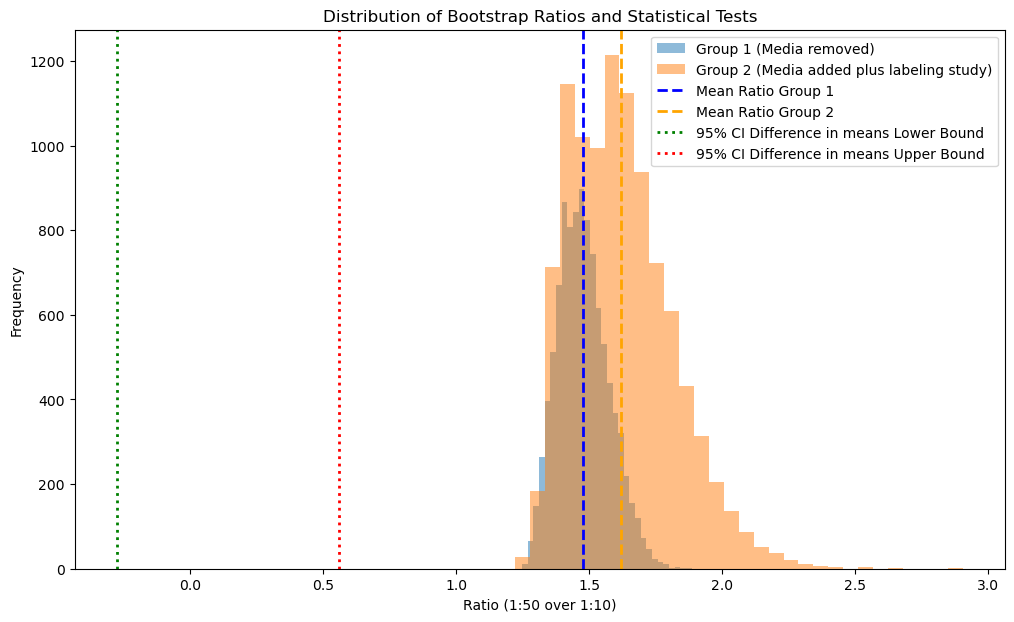

In [20]:
import matplotlib.pyplot as plt

# Plot the distribution of bootstrap ratios for both groups
plt.figure(figsize=(12, 7))
plt.hist(ratios_group1, bins=30, alpha=0.5, label='Group 1 (Media removed)')
plt.hist(ratios_group2, bins=30, alpha=0.5, label='Group 2 (Media added plus labeling study)')
plt.axvline(x=mean_ratio_group1, color='blue', linestyle='dashed', linewidth=2, label='Mean Ratio Group 1')
plt.axvline(x=mean_ratio_group2, color='orange', linestyle='dashed', linewidth=2, label='Mean Ratio Group 2')
plt.axvline(x=confidence_interval[0], color='green', linestyle='dotted', linewidth=2, label='95% CI Difference in means Lower Bound')
plt.axvline(x=confidence_interval[1], color='red', linestyle='dotted', linewidth=2, label='95% CI Difference in means Upper Bound')
plt.title('Distribution of Bootstrap Ratios and Statistical Tests')
plt.xlabel('Ratio (1:50 over 1:10)')
plt.ylabel('Frequency')
plt.legend()
plt.show()
# confidence interval calculated was for the difference in means between the two bootstrap distributions, not for the means themselves. A confidence interval that includes 0 suggests the mean difference between groups could be zero, indicating no significant difference



# Test whether the MSI is significantly different for each group

In [23]:
path = './data'

df = pd.read_csv(path + '/donor_overview_groups.csv', delimiter = ',')
df.head()


,Donor Name,Group,Ratio Doublings 1:50 vs 1:10,Age,Gender,Race
0,May F 22,0,1.33,36.45,Female,White
1,June M 22,0,2.33,57.72,Male,White
2,June M 22,0,1.31,57.72,Male,White
3,Jan M 23,0,1.26,49.08,Male,American Alaskan
4,Jan M 23,0,1.29,49.08,Male,American Alaskan


In [33]:
# Extract data for each group
group0 = df[df['Group'] == 0]['Ratio Doublings 1:50 vs 1:10']
group1 = df[df['Group'] == 1]['Ratio Doublings 1:50 vs 1:10']
group2 = df[df['Group'] == 2]['Ratio Doublings 1:50 vs 1:10']



In [34]:
 
# Perform ANOVA test
anova_result = f_oneway(group0, group1, group2)

anova_result

F_onewayResult(statistic=0.9047429494475755, pvalue=0.42437402837332305)

In [35]:
def bootstrap_mean_difference(group_a, group_b, n_bootstrap=10000):
    """Perform bootstrap sampling and calculate differences in means."""
    boot_diffs = []
    for _ in range(n_bootstrap):
        boot_a = np.random.choice(group_a, size=len(group_a), replace=True)
        boot_b = np.random.choice(group_b, size=len(group_b), replace=True)
        boot_diffs.append(np.mean(boot_b) - np.mean(boot_a))
    return boot_diffs

# Perform bootstrap sampling for differences in means
diff_group0_group1 = bootstrap_mean_difference(group0, group1)
diff_group0_group2 = bootstrap_mean_difference(group0, group2)
diff_group1_group2 = bootstrap_mean_difference(group1, group2)

# Calculate 95% confidence intervals for each difference
ci_group0_group1 = np.percentile(diff_group0_group1, [2.5, 97.5])
ci_group0_group2 = np.percentile(diff_group0_group2, [2.5, 97.5])
ci_group1_group2 = np.percentile(diff_group1_group2, [2.5, 97.5])

(ci_group0_group1, ci_group0_group2, ci_group1_group2)


(array([-0.3532625 ,  0.65451875]),
 array([-0.61401667,  0.12333333]),
 array([-0.72292708, -0.00790625]))

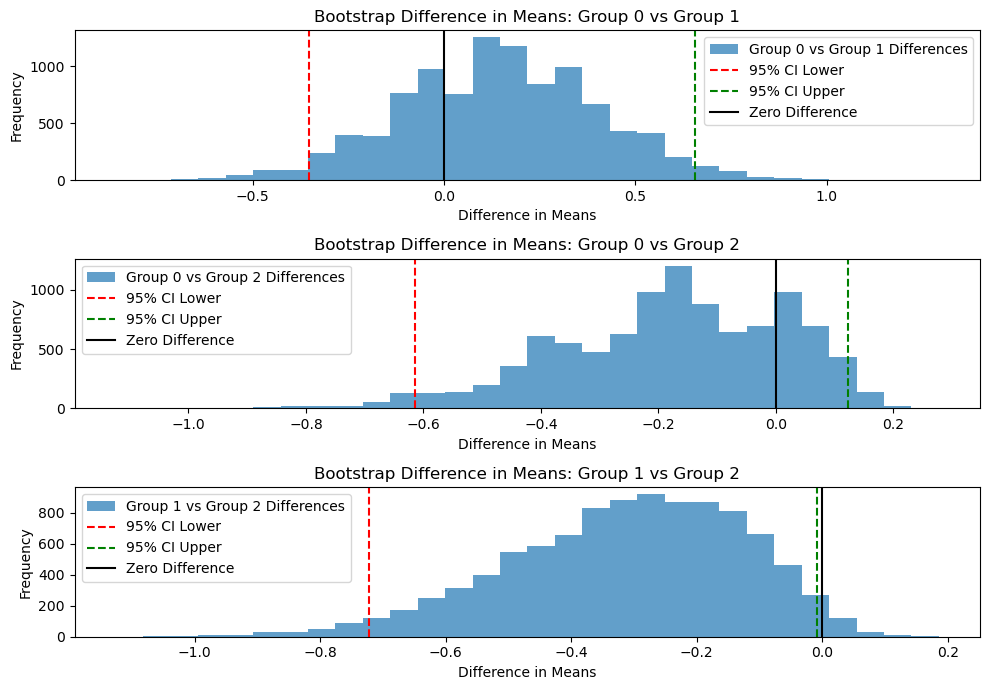

In [36]:
# Plotting the bootstrap differences and confidence intervals

# Combine the differences for plotting
bootstrap_differences = [diff_group0_group1, diff_group0_group2, diff_group1_group2]
group_labels = ['Group 0 vs Group 1', 'Group 0 vs Group 2', 'Group 1 vs Group 2']
cis = [ci_group0_group1, ci_group0_group2, ci_group1_group2]

plt.figure(figsize=(10, 7))

# Plot each set of differences
for i, diffs in enumerate(bootstrap_differences):
    plt.subplot(3, 1, i+1)
    plt.hist(diffs, bins=30, alpha=0.7, label=f'{group_labels[i]} Differences')
    plt.axvline(cis[i][0], color='red', linestyle='--', label='95% CI Lower')
    plt.axvline(cis[i][1], color='green', linestyle='--', label='95% CI Upper')
    plt.axvline(0, color='black', linestyle='-', label='Zero Difference')
    plt.legend()
    plt.xlabel('Difference in Means')
    plt.ylabel('Frequency')
    plt.title(f'Bootstrap Difference in Means: {group_labels[i]}')

plt.tight_layout()
plt.show()


# Power analysis

In [40]:
from statsmodels.stats.power import FTestAnovaPower

# Example parameters for power analysis
effect_size = 0.4  # Small to medium effect size; adjust based on your expectations or prior data
alpha = 0.05  # Significance level
power = 0.8  # Desired power
groups = 3  # Number of groups

# Create an F-test ANOVA power analysis object
power_analysis = FTestAnovaPower()

# Calculate the sample size required
sample_size = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, k_groups=groups)

sample_size


63.31040374486473

# Random forest

In [83]:
# Load the dataset
data = pd.read_csv(path + '/all_donors_all_variables.csv', delimiter=',')

# Check for missing values
print(data.isnull().sum())

# Handle missing values, for example, by dropping them
data_clean = data.dropna()
data_clean = data_clean.drop('Condition', axis =1)
data_clean = data_clean.drop('Expansion', axis =1)

# Transform categorical data into numerical data
data_num = pd.get_dummies(data_clean, columns=['Gender', 'Race'], dtype=float)


# Group by 'Donor Name' and compute the mean for each group
data_averaged = data_num.groupby('Donor Number').mean().reset_index()

# Example categorization based on quantiles
data_averaged['MSI_category'] = pd.qcut(data_averaged['MSI'], 3, labels=["low", "medium", "high"])



Donor Name                    0
Donor Number                  0
Age                           0
Gender                        0
Race                          0
Expansion                     0
Condition                     0
CD4%                          1
Baseline %Naive               1
Baseline %Effector            1
Baseline % Effector Memory    1
Baseline %Central Memory      1
1:10                          0
1:50                          0
DY                            0
MSI                           0
dtype: int64


/var/folders/r6/qxwj4pyd65zgnzfyvq_vk8sm0000gn/T/ipykernel_43721/2835889503.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_averaged = data_num.groupby('Donor Number').mean().reset_index()


In [84]:
data_averaged

,Donor Number,Age,CD4%,Baseline %Naive,Baseline %Effector,Baseline % Effector Memory,Baseline %Central Memory,1:10,1:50,DY,MSI,Gender_Female,Gender_Male,Race_American Alaskan,Race_Black,Race_Undisclosed,Race_White,MSI_category
0,W04702215189400S,36.4500,59.56000,43.580000,29.840000,3.720000,23.630000,3.526870,4.681800,2.832150,1.327470,1.00,0.00,0.0,0.0,0.0,1.0,low
1,W04702225213900I,57.9975,74.44875,46.715269,21.339083,16.544181,15.408966,3.056530,4.760550,3.836640,1.921970,0.25,0.75,0.0,0.0,0.0,1.0,high
2,W04702233220500U,33.9100,64.56000,26.810000,18.990000,9.840000,44.850000,1.730080,2.537590,1.951860,1.503285,0.00,1.00,0.0,0.0,0.0,1.0,high
3,W04702233221300U,42.9100,75.75000,28.080000,13.260000,6.430000,53.090000,3.048205,4.096150,4.089155,1.343660,0.00,1.00,0.0,0.0,0.0,1.0,medium
4,W04702236737800Y,28.4500,64.38000,37.750000,19.640000,7.670000,35.730000,2.670155,3.071620,2.534125,1.151370,0.00,1.00,0.0,0.0,1.0,0.0,low
5,W04702240070100P,17.4760,64.86875,27.647500,14.192500,31.997500,26.147500,3.355478,5.135065,4.351287,1.516300,1.00,0.00,0.0,1.0,0.0,0.0,high
6,W04702307451100P,49.0800,71.70000,44.920000,19.570000,18.640000,16.870000,3.920403,5.128883,4.481150,1.298807,0.00,1.00,1.0,0.0,0.0,0.0,low
7,W04702307451600F,52.6800,67.27000,36.190000,12.190000,31.570000,20.060000,3.013243,4.225300,3.245237,1.388533,1.00,0.00,0.0,0.0,0.0,1.0,medium
8,W047023331014006,34.0000,66.70000,48.240000,3.130000,28.250000,19.410000,4.345880,6.274485,5.937210,1.443185,0.00,1.00,0.0,0.0,1.0,0.0,medium


In [103]:
from sklearn.model_selection import train_test_split

X = data_averaged.drop('MSI_category', axis=1)  # Features
X = X.drop('Donor Number', axis=1)
X = X.drop('MSI', axis=1)
X = X.drop('1:50', axis=1)
X = X.drop('1:10', axis=1)
X = X.drop('DY', axis=1)
y = data_averaged['MSI_category']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


In [104]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [105]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        high       0.00      0.00      0.00         2
         low       0.20      1.00      0.33         1
      medium       0.00      0.00      0.00         2

    accuracy                           0.20         5
   macro avg       0.07      0.33      0.11         5
weighted avg       0.04      0.20      0.07         5



/Users/paulajosefine/Documents/PhD/Scripts/Starfysh/.conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/paulajosefine/Documents/PhD/Scripts/Starfysh/.conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/paulajosefine/Documents/PhD/Scripts/Starfysh/.conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

In [106]:
importances = clf.feature_importances_


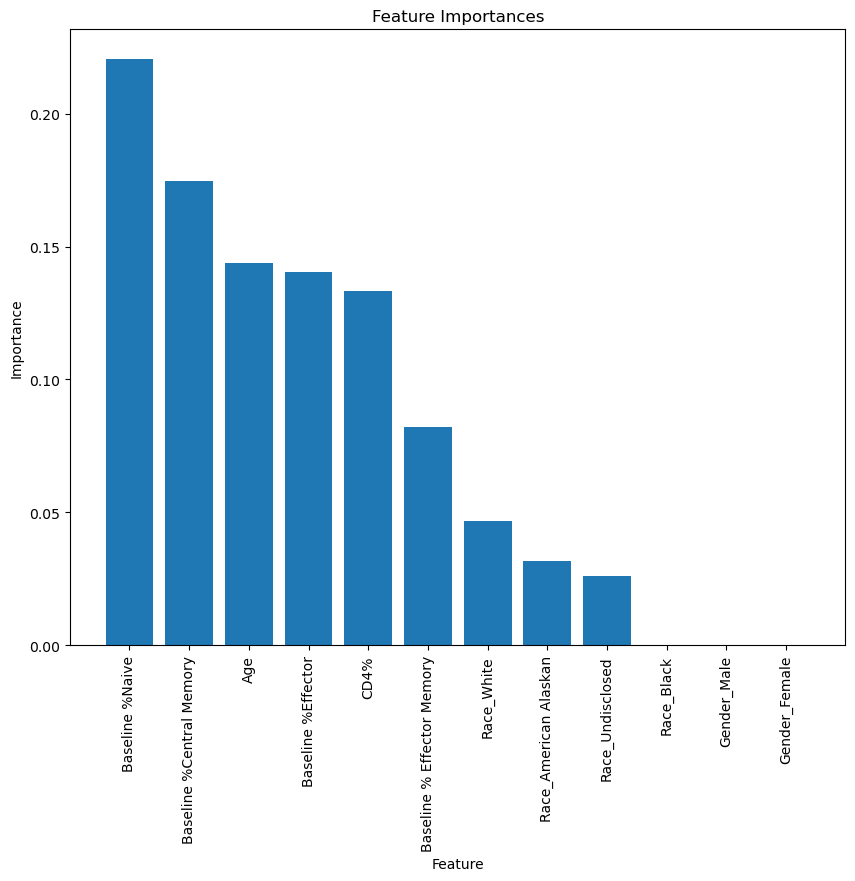

In [107]:
# Get the feature names
feature_names = X_train.columns

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange the feature names so they match the sorted feature importances
sorted_feature_names = [feature_names[i] for i in indices]

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), sorted_feature_names, rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

Elapsed time to compute the importances: 9.806 seconds


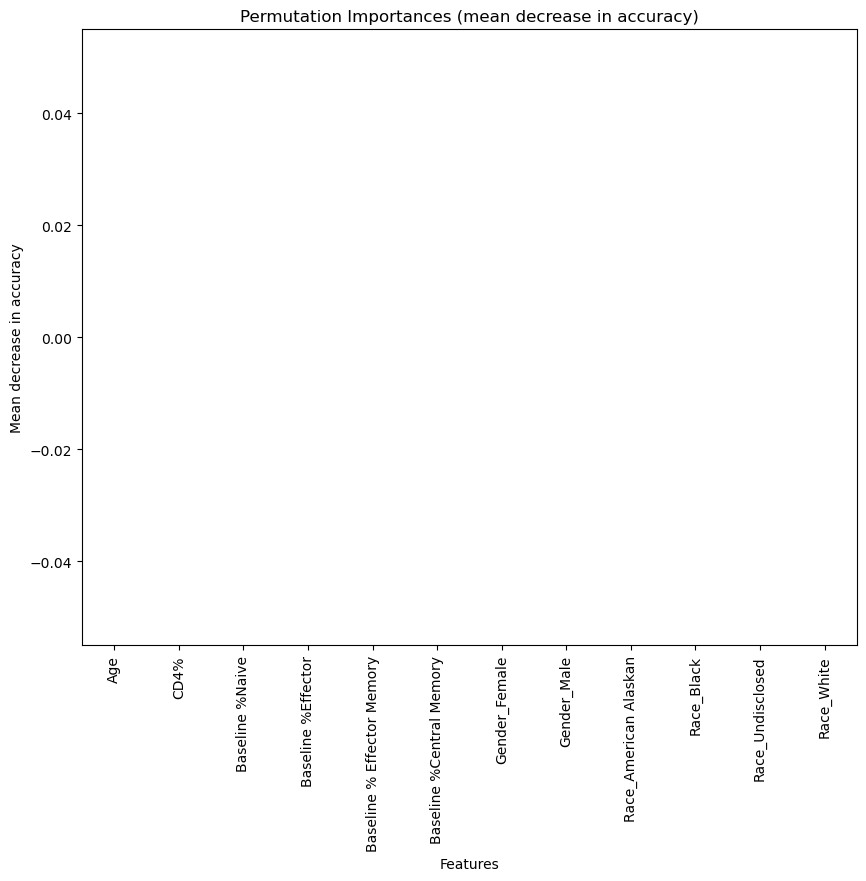

In [109]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.inspection import permutation_importance
import time

# Assuming 'forest' is your trained RandomForestClassifier model
# and 'X_test', 'y_test' are your testing datasets

start_time = time.time()

# Compute permutation importances
result = permutation_importance(clf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

# Convert the importances into a pandas Series for easy plotting
forest_importances = pd.Series(result.importances_mean, index=feature_names)

# Sort the importances
forest_importances_sorted = forest_importances.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
forest_importances_sorted.plot(kind='bar')
plt.title('Permutation Importances (mean decrease in accuracy)')
plt.ylabel('Mean decrease in accuracy')
plt.xlabel('Features')
plt.xticks(rotation=90)  # Rotate feature names for better readability
plt.show()
